#**Proyek Machine Learning Terapan 2**

- **Nama:** Sulistiani
- **Email:** lisasa2lilisa@gmail.com
- **ID Dicoding:** hi_itslizeu

## **Import Library**

In [150]:
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

## **Import Dataset**

In [151]:
df = pd.read_csv('manga.csv')

## **Assessing Data**

In [152]:
df.shape

(10000, 16)

In [153]:
df.head()

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters,Status,Published,Genres,Themes,Demographics,Serialization,Author
0,Berserk,9.47,334154,1,1,"670,559","123,574",Unknown,Unknown,Publishing,"Aug 25, 1989 to ?","['Action', 'Adventure', 'Award Winning', 'Dram...","['Gore', 'Military', 'Mythology', 'Psychologic...",['Seinen'],Young Animal,"Miura, Kentarou (Story & Art), Studio Gaga (Art)"
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.30,157522,2,26,"257,957","43,113",24,96,Finished,"Jan 19, 2004 to Apr 19, 2011","['Action', 'Adventure', 'Mystery', 'Supernatur...",[],"['Seinen', 'Shounen']",Ultra Jump,"Araki, Hirohiko (Story & Art)"
2,Vagabond,9.25,138009,3,15,"368,332","40,575",37,327,On Hiatus,"Sep 3, 1998 to May 21, 2015","['Action', 'Adventure', 'Award Winning']","['Historical', 'Samurai']",['Seinen'],Morning,"Inoue, Takehiko (Story & Art), Yoshikawa, Eiji..."
3,One Piece,9.22,368951,4,3,"603,122","115,123",Unknown,Unknown,Publishing,"Jul 22, 1997 to ?","['Action', 'Adventure', 'Fantasy']",[],['Shounen'],Shounen Jump (Weekly),"Oda, Eiichiro (Story & Art)"
4,Monster,9.15,94806,5,29,"238,291","20,674",18,162,Finished,"Dec 5, 1994 to Dec 20, 2001","['Award Winning', 'Drama', 'Mystery']","['Adult Cast', 'Psychological']",['Seinen'],Big Comic Original,"Urasawa, Naoki (Story & Art)"


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          10000 non-null  object 
 1   Score          10000 non-null  float64
 2   Vote           10000 non-null  int64  
 3   Ranked         10000 non-null  int64  
 4   Popularity     10000 non-null  int64  
 5   Members        10000 non-null  object 
 6   Favorite       10000 non-null  object 
 7   Volumes        10000 non-null  object 
 8   Chapters       10000 non-null  object 
 9   Status         10000 non-null  object 
 10  Published      10000 non-null  object 
 11  Genres         10000 non-null  object 
 12  Themes         10000 non-null  object 
 13  Demographics   10000 non-null  object 
 14  Serialization  8211 non-null   object 
 15  Author         9985 non-null   object 
dtypes: float64(1), int64(3), object(12)
memory usage: 1.2+ MB


## **Checking Missing Values**

In [155]:
df.isnull().sum()

,0
Title,0
Score,0
Vote,0
Ranked,0
Popularity,0
Members,0
Favorite,0
Volumes,0
Chapters,0
Status,0


In [156]:
df.duplicated().any()

np.False_

## **Data Preparation**

### **Cleaning Data**

#### **Menghapus Kolom**

In [157]:
df.drop(columns=['Themes',	'Demographics',	'Serialization', 'Members',	'Favorite'], inplace=True)

#### **Membersihkan Data Kosong**

In [158]:
df = df[df['Genres'].str.strip() != '[]']

#### **IQR**

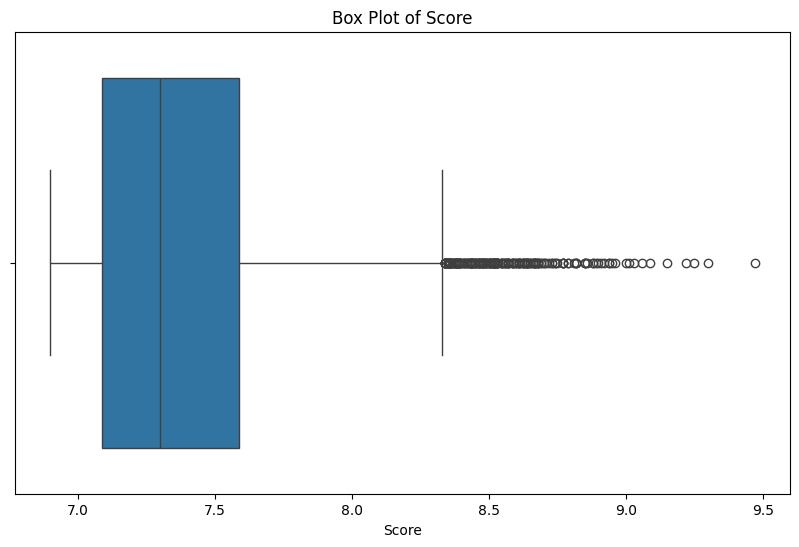

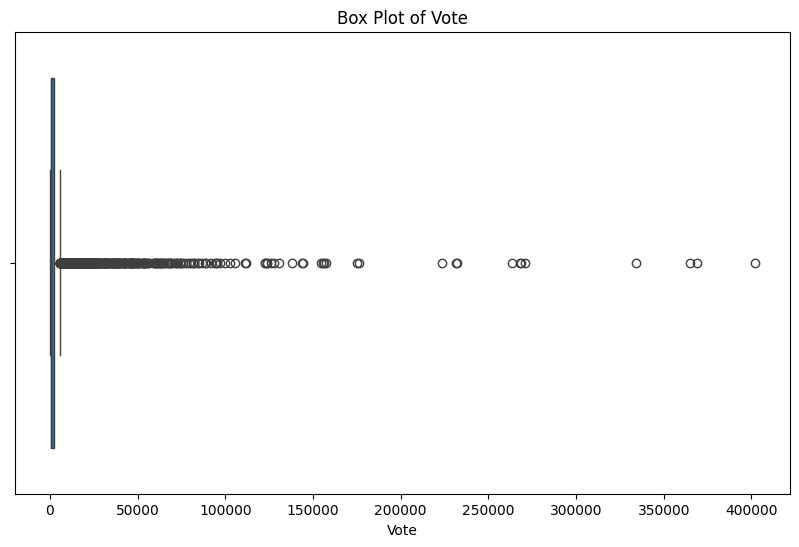

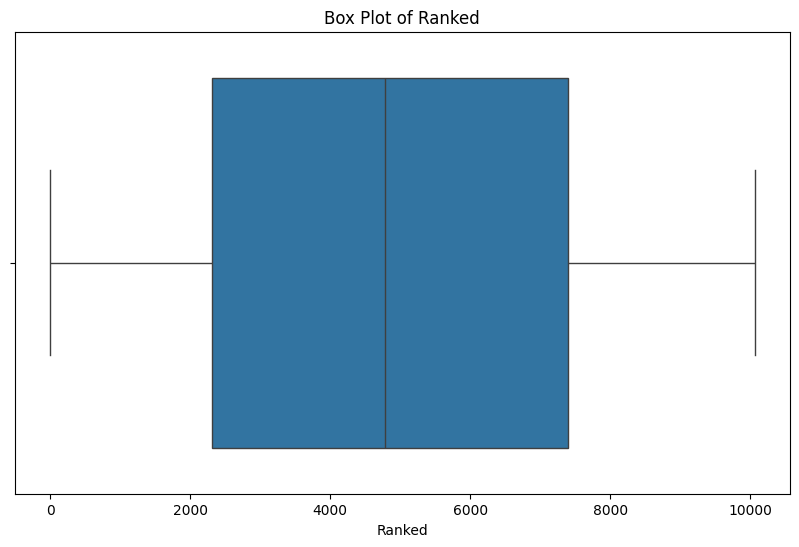

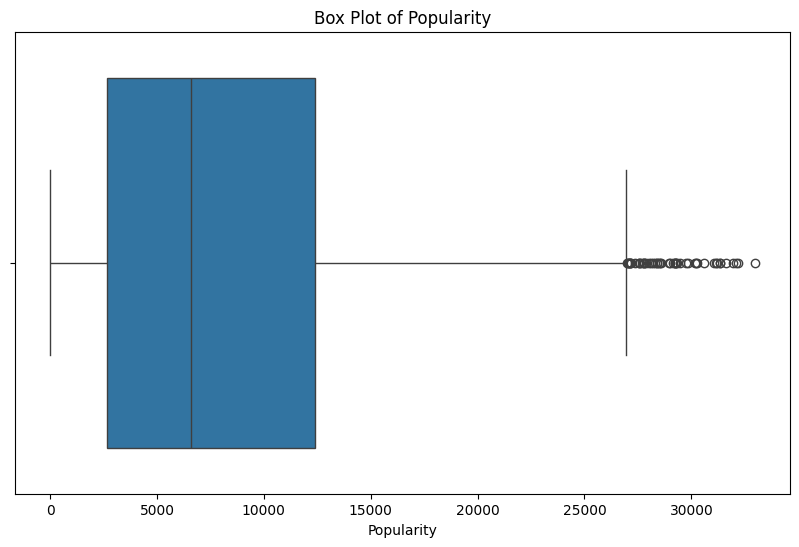

In [159]:
numeric_features = df.select_dtypes(include=np.number).columns.tolist()

for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

In [160]:
Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)
IQR = Q3 - Q1

In [161]:
# Filter dataframe untuk hanya menyimpan baris yang tidak mengandung outliers pada kolom numerik
condition = ~((df[numeric_features] < (Q1 - 1.5 * IQR)) | (df[numeric_features] > (Q3 + 1.5 * IQR))).any(axis=1)
df_filtered_numeric = df.loc[condition, numeric_features]

# Menggabungkan kembali dengan kolom kategorikal
categorical_features = df.select_dtypes(include=['object']).columns
df = pd.concat([df_filtered_numeric, df.loc[condition, categorical_features]], axis=1)

### **Data Transformation**

#### **Encoding**

In [162]:
df['Genres'] = df['Genres'].astype(str)

df['Genres_list'] = df['Genres'].str.split(',')

genres_encoded = df['Genres_list'].str.join('|').str.get_dummies()

#### **Feature Engineering**

In [163]:
feature_cols = df.drop(['Title','Genres'], axis=1)
X = feature_cols

#### **Handling Missing Value**

In [164]:
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].replace(['Unknown', '-', 'Not available'], np.nan)
        X[col] = pd.to_numeric(X[col], errors='coerce')

#### **Feature Selection**

In [165]:
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
         if X[col].isnull().any():
            median_val = X[col].median()
            if not np.isnan(median_val):
                X[col] = X[col].fillna(median_val)
            else:
                X[col] = X[col].fillna(0)


if X.isnull().sum().sum() > 0:
    print("Warning: There are still NaN values in the DataFrame after cleaning.")
    print(X.isnull().sum()[X.isnull().sum() > 0])

X_with_genres = pd.concat([X, genres_encoded], axis=1)

In [166]:
X_final = X.copy()

# Tambahkan fitur genre yang di-encode
X_final = pd.concat([X_final, genres_encoded], axis=1)


# Tambahkan fitur Status (jika kategorikal, lakukan one-hot encoding)
if 'Status' in df.columns:
    status_encoded = pd.get_dummies(df['Status'], prefix='Status')
    X_final = pd.concat([X_final, status_encoded], axis=1)
else:
     print("Warning: 'Status' column not found in df.")


if 'Published' in df.columns:
    try:
        df['Published_Year'] = pd.to_datetime(df['Published'], errors='coerce').dt.year
        published_numeric = df['Published_Year'].fillna(df['Published_Year'].median())
        X_final['Published_Year'] = published_numeric
    except:
        if pd.api.types.is_numeric_dtype(df['Published']):
             X_final['Published'] = df['Published']
        else:
             print("Warning: Could not process 'Published' column. It's not numeric and date conversion failed.")
else:
     print("Warning: 'Published' column not found in df.")

# Tambahkan fitur Score
if 'Score' in df.columns and pd.api.types.is_numeric_dtype(df['Score']):
     X_final['Score'] = df['Score']
elif 'Score' in df.columns:
     print("Warning: 'Score' column is not numeric. Please check cleaning steps.")
else:
     print("Warning: 'Score' column not found in df.")


# Pastikan tidak ada kolom non-numerik di X_final sebelum melatih model
X_final = X_final.select_dtypes(include=np.number)
X_final = X_final.dropna()

print(f"Shape of X_final: {X_final.shape}")
print("Columns in X_final:", X_final.columns.tolist())

<ipython-input-166-13388d480361>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Published_Year'] = pd.to_datetime(df['Published'], errors='coerce').dt.year


Shape of X_final: (6281, 62)
Columns in X_final: ['Score', 'Vote', 'Ranked', 'Popularity', 'Volumes', 'Chapters', 'Status', 'Published', 'Author', 'Genres_list', " 'Adventure'", " 'Adventure']", " 'Award Winning'", " 'Award Winning']", " 'Boys Love'", " 'Boys Love']", " 'Comedy'", " 'Comedy']", " 'Drama'", " 'Drama']", " 'Ecchi']", " 'Fantasy'", " 'Fantasy']", " 'Girls Love'", " 'Girls Love']", " 'Gourmet'", " 'Gourmet']", " 'Horror'", " 'Horror']", " 'Mystery'", " 'Mystery']", " 'Romance'", " 'Romance']", " 'Sci-Fi'", " 'Sci-Fi']", " 'Slice of Life'", " 'Slice of Life']", " 'Sports'", " 'Sports']", " 'Supernatural'", " 'Supernatural']", " 'Suspense'", " 'Suspense']", "['Action'", "['Adventure'", "['Avant Garde'", "['Award Winning'", "['Boys Love'", "['Comedy'", "['Drama'", "['Fantasy'", "['Girls Love'", "['Gourmet'", "['Horror'", "['Mystery'", "['Romance'", "['Sci-Fi'", "['Slice of Life'", "['Sports'", "['Supernatural'", "['Suspense'", 'Published_Year']


## **Exploratory Data Analyst**

### **Score (Rating)**

In [167]:
score = df.groupby("Score").agg({"Score":"count"})
df.sort_values(by="Score",ascending=False ).reset_index(drop=True).head()

,Score,Vote,Ranked,Popularity,Title,Volumes,Chapters,Status,Published,Genres,Author,Genres_list,Published_Year
0,8.33,4235,276,1695,Naruto Shinden Series (Naruto: Itachi's Story),3,11,Finished,"Sep 4, 2015 to Nov 4, 2015","['Action', 'Adventure', 'Fantasy']","Kishimoto, Masashi (Art), Yano, Takashi (Story...","[['Action', 'Adventure', 'Fantasy']]",NaN
1,8.32,5180,278,1628,Full Metal Panic! Sigma,19,90,Finished,"Apr 9, 2005 to Sep 9, 2013","['Action', 'Romance']","Gatou, Shouji (Story), Ueda, Hiroshi (Art)","[['Action', 'Romance']]",NaN
2,8.32,4588,279,1207,Piano no Mori (Forest of Piano),26,242,Finished,"Aug 5, 1998 to Nov 5, 2015","['Award Winning', 'Drama']","Isshiki, Makoto (Story & Art)","[['Award Winning', 'Drama']]",NaN
3,8.31,5791,282,1266,Higurashi no Naku Koro ni Kai: Meakashi-hen (H...,4,21,Finished,"Jun 26, 2006 to Feb 26, 2008","['Drama', 'Horror', 'Mystery']","Houjou, Yutori (Art), Ryukishi07 (Story)","[['Drama', 'Horror', 'Mystery']]",NaN
4,8.31,2184,285,2846,Bleach: Can't Fear Your Own World,3,32,Finished,"Aug 4, 2017 to Dec 4, 2018","['Action', 'Supernatural']","Kubo, Tite (Art), Narita, Ryohgo (Story)","[['Action', 'Supernatural']]",NaN


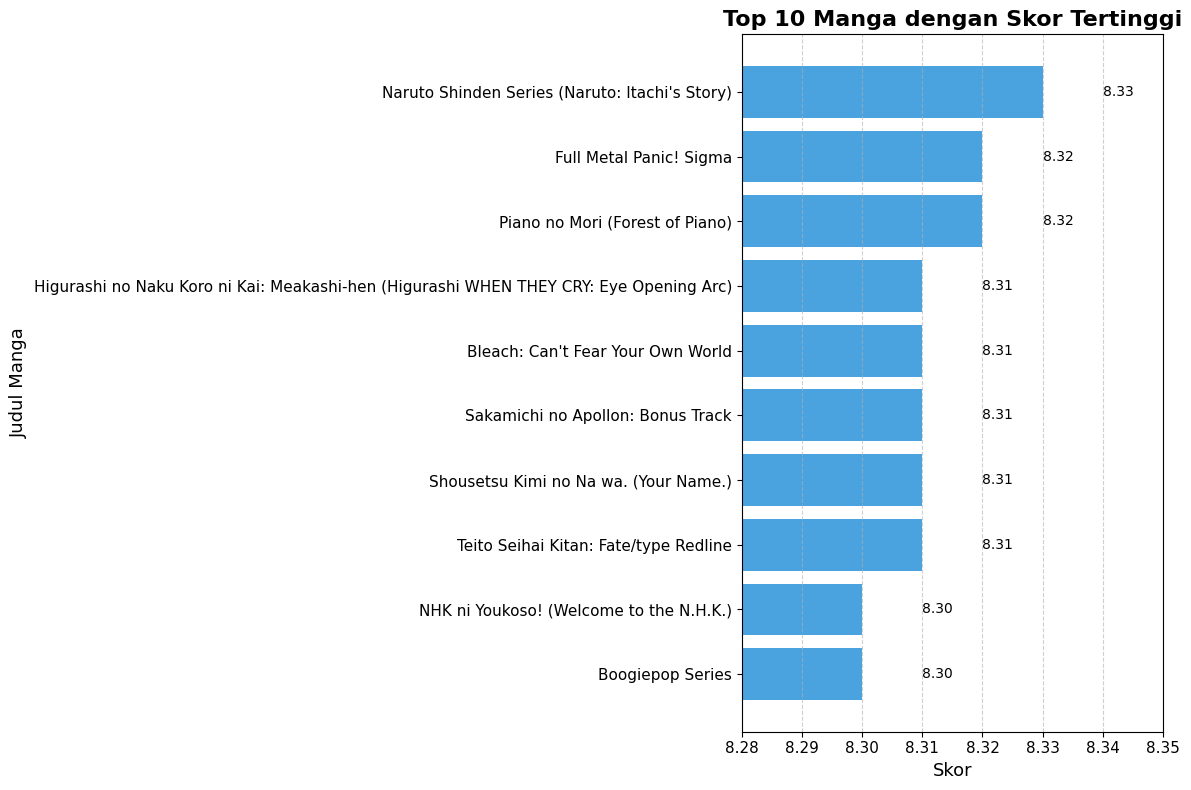

In [168]:
# Mengurutkan dataframe berdasarkan Score tertinggi dan mengambil 10 teratas
top_scores = df[['Title', 'Score']].dropna().sort_values(by='Score', ascending=False).head(10)

# Visualisasi
plt.figure(figsize=(12, 8))  # Ukuran figure ditingkatkan untuk kejelasan

# Membuat bar chart horizontal
bars = plt.barh(top_scores['Title'], top_scores['Score'], color='#4aa3df')

# Judul dan label sumbu
plt.title('Top 10 Manga dengan Skor Tertinggi', fontsize=16, weight='bold')
plt.xlabel('Skor', fontsize=13)
plt.ylabel('Judul Manga', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Membalik sumbu Y agar skor tertinggi di atas
plt.gca().invert_yaxis()

# Menambahkan label skor di ujung bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}', va='center', fontsize=10, color='black')

# Fokus pada range skor yang sesuai jika semua mendekati angka tinggi
min_score = top_scores['Score'].min() - 0.02
max_score = top_scores['Score'].max() + 0.02
plt.xlim(min_score, max_score)

# Memberi grid ringan pada sumbu X
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### **Published**

In [169]:
published = df.groupby("Published").agg({"Published":"min"})
df.sort_values(by="Published", ascending=True).reset_index(drop=True).head()

,Score,Vote,Ranked,Popularity,Title,Volumes,Chapters,Status,Published,Genres,Author,Genres_list,Published_Year
0,7.43,180,3477,23686,Gensou Suikoden V: Reimei no Shiro,4,40,Finished,"10, 2008 to 8, 2009","['Action', 'Adventure', 'Fantasy']","Tsuge, Mizuki (Story & Art)","[['Action', 'Adventure', 'Fantasy']]",NaN
1,7.29,167,4802,22475,Captain Ken,2,Unknown,Finished,1960 to 1961,"['Action', 'Sci-Fi']","Tezuka, Osamu (Story & Art)","[['Action', 'Sci-Fi']]",NaN
2,7.23,607,5516,5049,u (GeGeGe no Kitaro),17,117,Finished,1965 to 1986,"['Comedy', 'Supernatural']","Mizuki, Shigeru (Story & Art)","[['Comedy', 'Supernatural']]",NaN
3,7.50,242,2894,11940,Sabu to Ichi Torimono Hikae,17,83,Finished,1966 to Mar 1972,"['Action', 'Adventure', 'Drama', 'Romance', 'S...","Ishinomori, Shoutarou (Story & Art)","[['Action', 'Adventure', 'Drama', 'Romance'...",NaN
4,7.27,276,5025,13835,Wolf Guy,2,Unknown,Finished,1970 to 1971,"['Action', 'Fantasy']","Hirai, Kazumasa (Story), Sakaguchi, Hisashi (Art)","[['Action', 'Fantasy']]",NaN


<ipython-input-170-32d0f345cee9>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Year'] = pd.to_datetime(df['Published'], errors='coerce').dt.year


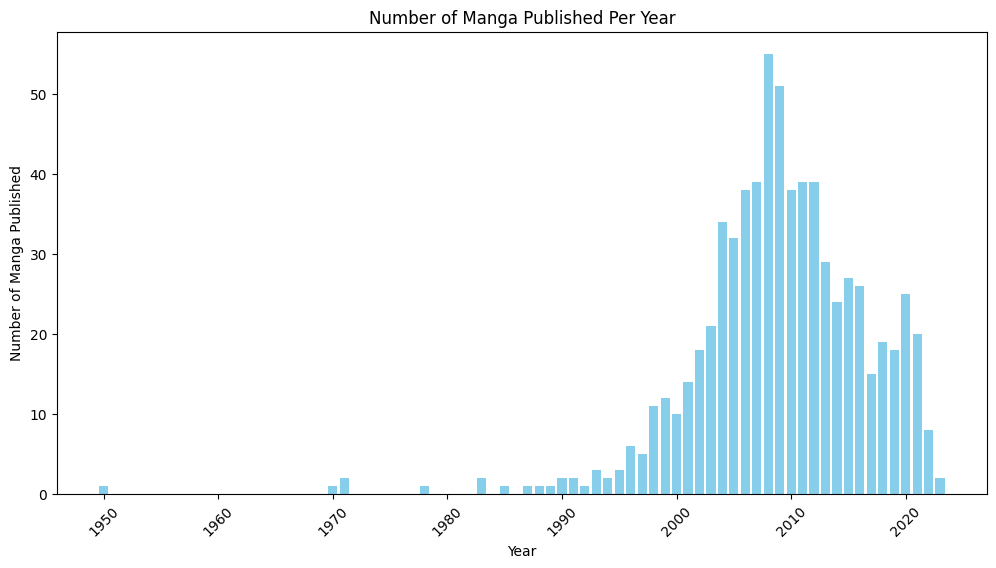

In [170]:
df['Year'] = pd.to_datetime(df['Published'], errors='coerce').dt.year

counts_per_year = df.groupby('Year').size().reset_index(name='Count')

plt.figure(figsize=(12,6))
plt.bar(counts_per_year['Year'], counts_per_year['Count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Manga Published')
plt.title('Number of Manga Published Per Year')
plt.xticks(rotation=45)
plt.show()


### **Status**

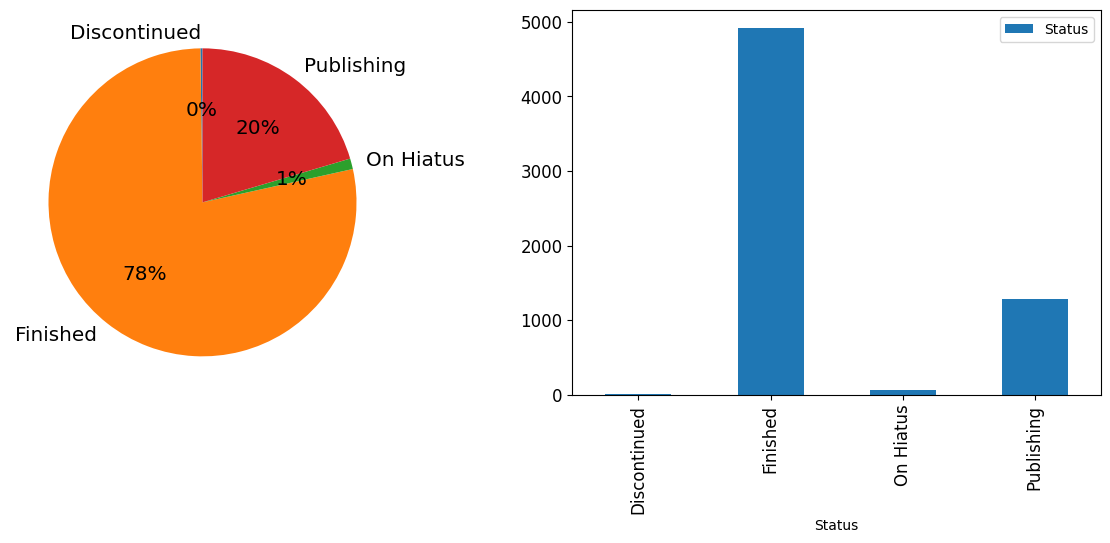

In [171]:
Status = df.groupby("Status").agg({"Status":"count"})

figsize = (15,5)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=figsize)
Status.plot.pie(ax=ax1,y="Status", legend=False, autopct='%1.f%%', startangle=90, fontsize="x-large")
ax1.set_ylabel('')
Status.plot.bar(ax=ax2,  fontsize="large")

plt.show()

### **Genre**

Top 10 Genre Terbanyak:
['Comedy'           1898
['Action'           1733
'Romance']          1629
'Supernatural']     1171
['Drama'            1039
'Fantasy']           911
'Romance'            849
'Slice of Life']     832
'Fantasy'            760
'Drama'              713
Name: count, dtype: int64


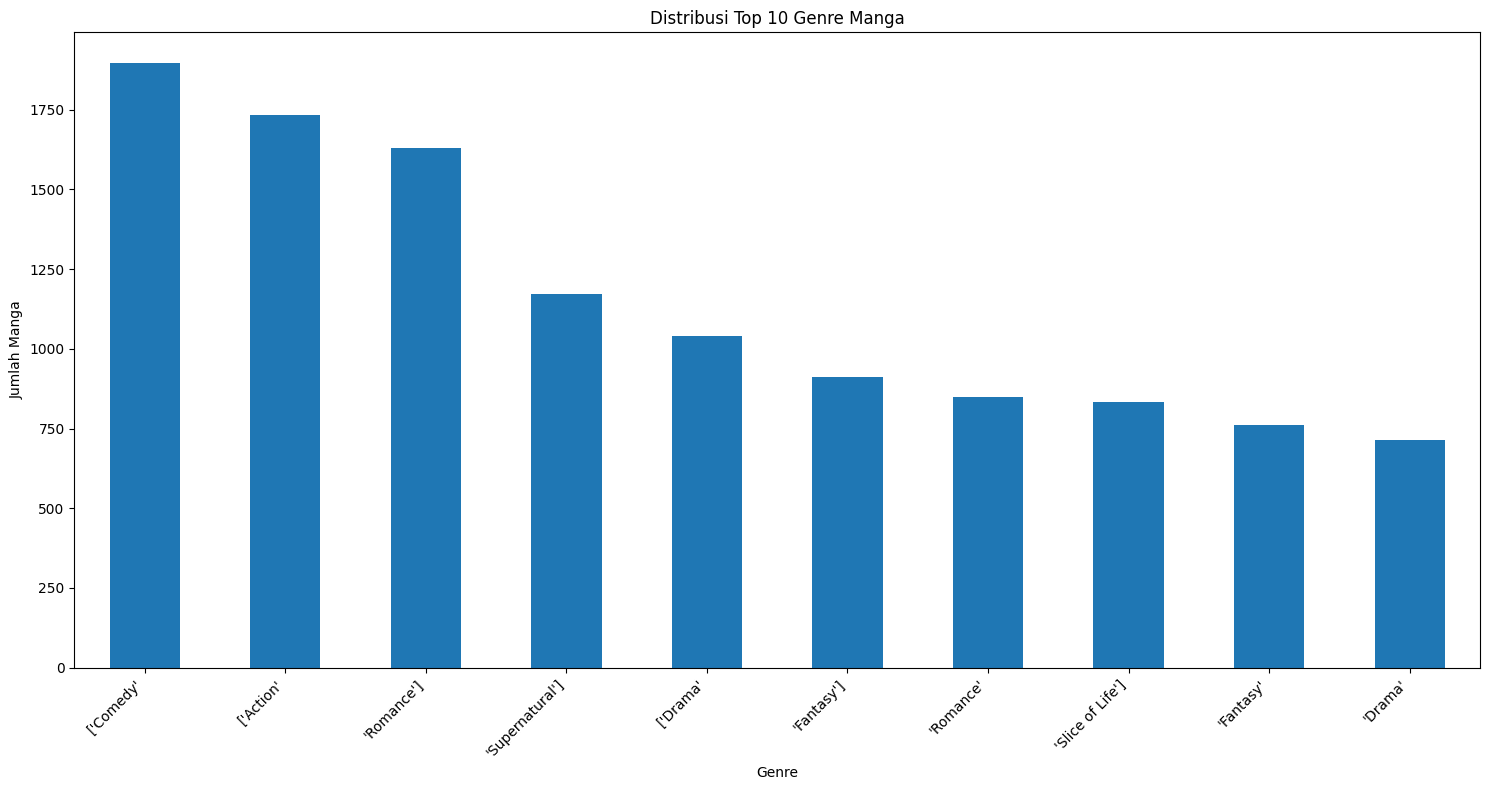

In [172]:
# Melihat Top Genre Terbanyak
all_genres = [genre.strip() for genres_list in df['Genres_list'].dropna() for genre in genres_list]

genre_counts = pd.Series(all_genres).value_counts()

# Menampilkan 10 genre teratas
print("Top 10 Genre Terbanyak:")
print(genre_counts.head(10))

# Visualisasi Distribusi Genre (Top 10)
plt.figure(figsize=(15, 8))
genre_counts.head(10).plot(kind='bar')
plt.title('Distribusi Top 10 Genre Manga')
plt.xlabel('Genre')
plt.ylabel('Jumlah Manga')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Modelling**

#### **TFIDF**

In [173]:
tfid = TfidfVectorizer()
tfid.fit(df['Genres'])

tfid.get_feature_names_out()

array(['action', 'adventure', 'avant', 'award', 'boys', 'comedy', 'drama',
       'ecchi', 'fantasy', 'fi', 'garde', 'girls', 'gourmet', 'horror',
       'life', 'love', 'mystery', 'of', 'romance', 'sci', 'slice',
       'sports', 'supernatural', 'suspense', 'winning'], dtype=object)

In [174]:
tfidf_matrix = tfid.fit_transform(df['Genres'])
tfidf_matrix.shape

(6281, 25)

In [175]:
tfidf_matrix.todense()

matrix([[0.53498904, 0.68196989, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.77707392, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.67066833],
        ...,
        [0.        , 0.        , 0.        , ..., 0.58583693, 0.        ,
         0.        ],
        [0.3915178 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [176]:
df_tfidf = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfid.get_feature_names_out(),
    index=df['Title']
)

df_tfidf.sample(10, axis=0).sample(22, axis=1)

,drama,slice,avant,love,ecchi,fi,life,winning,suspense,mystery,...,fantasy,boys,comedy,adventure,supernatural,romance,garde,action,sci,award
Title,,,,,,,,,,,,,,,,,,,,,
Utakata ni Warau,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0000,0.747292,0.000000,0.0,0.664496,0.0,0.0
"Kore wa Zombie desu ka? Hai, Anata no Yome desu",0.000000,0.0,0.0,0.0,0.799052,0.0,0.0,0.0,0.0,0.0,...,0.448023,0.0,0.400989,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0
Rec: Kimi ga Naita Hi,0.759680,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0000,0.000000,0.650298,0.0,0.000000,0.0,0.0
Yari no Yuusha no Yarinaoshi (The Reprise of the Spear Hero),0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.590279,0.0,0.000000,0.8072,0.000000,0.000000,0.0,0.000000,0.0,0.0
Yankee-kun to Hakujou Girl (Love's in Sight!),0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.717494,0.0000,0.000000,0.696564,0.0,0.000000,0.0,0.0
Kingdom Hearts Re:coded,0.569114,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.560669,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.601465,0.0,0.0
Sable Prince,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.754851,0.0,0.000000,0.0000,0.000000,0.655897,0.0,0.000000,0.0,0.0
Ore to Atashi no Kareshi-sama,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.717494,0.0000,0.000000,0.696564,0.0,0.000000,0.0,0.0
Itou Junji Kyoufu Manga Collection: Circus ga Kita,0.407987,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0000,0.484904,0.000000,0.0,0.000000,0.0,0.0


#### **Consine Similiarity**

In [177]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.41572603, 0.        , ..., 0.24216748, 0.20945773,
        0.        ],
       [0.41572603, 1.        , 0.        , ..., 0.26557203, 0.30423827,
        0.40930339],
       [0.        , 0.        , 1.        , ..., 0.1561894 , 0.        ,
        0.24072133],
       ...,
       [0.24216748, 0.26557203, 0.1561894 , ..., 1.        , 0.        ,
        0.64883907],
       [0.20945773, 0.30423827, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.40930339, 0.24072133, ..., 0.64883907, 0.        ,
        1.        ]])

In [178]:
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=df['Title'],
    columns=df['Title']
)

print(f"Ukuran cosine_sim_df: {cosine_sim_df.shape[0]} baris x {cosine_sim_df.shape[1]} kolom")

sample_matrix = cosine_sim_df.sample(5, axis=1).sample(5, axis=0)
display(sample_matrix)

Ukuran cosine_sim_df: 6281 baris x 6281 kolom


Title,Gekijouban Pocket Monster AG: Mew to Hadou no Yuusha Lucario (Pokémon: Lucario and the Mystery of Mew),Akita Imokko! Ebina-chan,Meister,Higurashi no Naku Koro ni Gaiden: Nekogoroshi-hen,Houkago Guitar
Title,,,,,
Ojousama no Himitsu♥,0.000000,0.255908,0.270449,0.000000,0.000000
Hoshikuzu Gakuen C Course,0.000000,0.255908,0.270449,0.000000,0.000000
Blend S,0.000000,1.000000,0.134442,0.000000,0.645362
Salty Studio,0.000000,0.944954,0.127041,0.000000,0.609837
Stravaganza: Isai no Hime (Stravaganza: The Queen in the Iron Mask),0.724726,0.000000,0.000000,0.191952,0.000000


In [179]:
def manga_recommendations(manga_name, similarity_data=cosine_sim_df, items=df[['Title', 'Genres']], k=10):
    result = items[items['Title'].str.contains(manga_name, case=False, na=False)]

    if len(result) > 0:
        return result.head(k)

    if manga_name not in similarity_data.columns:
        return f"Anime '{manga_name}' tidak ditemukan dalam data similarity."

    similarity_scores = similarity_data[manga_name].to_numpy()
    top_indices = similarity_scores.argsort()[::-1]
    similar_names = [similarity_data.columns[idx] for idx in top_indices if similarity_data.columns[idx] != manga_name][:k]
    return pd.DataFrame({'Title': similar_names}).merge(items, on='Title', how='left')

In [180]:
manga_recommendations("One Piece")

,Title,Genres
542,One Piece: Episode A (One Piece: Ace's Story),"['Action', 'Adventure', 'Fantasy']"
857,Gekijouban One Piece: Stampede,"['Action', 'Adventure', 'Comedy', 'Drama', 'Fa..."
899,One Piece Novel: A (One Piece: Ace's Story),"['Action', 'Adventure', 'Comedy', 'Fantasy']"
2239,"One Piece: Roronoa Zoro, Umi ni Chiru (One Pie...","['Action', 'Adventure', 'Drama', 'Fantasy']"
3542,One Piece Novel: Law,"['Action', 'Adventure', 'Fantasy']"
3837,One Piece: Vivi no Bouken (One Piece: Vivi's A...,"['Action', 'Adventure', 'Comedy', 'Drama', 'Fa..."
4735,One Piece: Mugiwara Daigekijou,"['Comedy', 'Fantasy']"
4746,One Piece Party,"['Action', 'Adventure', 'Comedy', 'Fantasy']"
7498,Shokugeki no Sanji (One Piece: Shokugeki no Sa...,"['Comedy', 'Gourmet']"
7799,One Piece: Loguetown-hen,"['Action', 'Adventure', 'Fantasy']"


#### **K-Nearest Neighbors**

In [181]:
manga_title_to_recommend = 'One Piece'

query_result = df[df['Title'].str.contains(manga_title_to_recommend, case=False, na=False)]

if not query_result.empty:
    # Ambil index pertama yang cocok
    manga_index = query_result.index[0]

    # Ambil vektor fiturnya dari X_final
    if X_final.isnull().sum().sum() > 0:
        print("Warning: X_final still contains NaN values.")

    manga_features = X_final.iloc[manga_index].values.reshape(1, -1)

    # Cari tetangga terdekat
    neigh = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
    # Fit the model with the data
    neigh.fit(X_final) # <-- Tambahkan baris ini

    distances, indices = neigh.kneighbors(manga_features)

    print(f'Recommendations for "{manga_title_to_recommend}":\n')

    # Mulai dari 1 karena 0 adalah dirinya sendiri
    for i in range(1, len(distances.flatten())):
        idx = indices.flatten()[i]
        distance = distances.flatten()[i]
        # Pastikan idx valid untuk df sebelum mengaksesnya
        if idx < len(df):
            recommended_title = df.iloc[idx]['Title']
            print(f'{i}: {recommended_title}, with a distance of {distance:.4f}')
        else:
            print(f"Warning: Index {idx} out of bounds for df.")

else:
    print(f"Manga '{manga_title_to_recommend}' not found in the dataset.")

Recommendations for "One Piece":

1: Ghost Teller, with a distance of 0.0008
2: Seishun Buta Yarou wa Petit Devil Kouhai no Yume wo Minai (Rascal Does Not Dream of Petite Devil Kohai), with a distance of 0.0008
3: Gakkougurashi! Otayori (School-Live! Letters), with a distance of 0.0013
4: You're So Cool, with a distance of 0.0015
5: The Last: Naruto the Movie, with a distance of 0.0015


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


## **Evaluation**

In [182]:
def precision_at_k(recommendations, ground_truth, k=5):
    if not recommendations or not ground_truth:
        return 0.0
    recommended_k = recommendations[:k]
    relevant = [item for item in recommended_k if item in ground_truth]
    return len(relevant) / k

def recall_at_k(recommendations, ground_truth, k=5):
    if not recommendations or not ground_truth:
        return 0.0
    recommended_k = recommendations[:k]
    relevant = [item for item in recommended_k if item in ground_truth]
    return len(relevant) / len(ground_truth)

# Data ground truth (item yang benar-benar disukai user)
ground_truth = [
    ['Naruto', 'One Piece', 'Bleach'],  # user 1
    ['Attack on Titan', 'Death Note'],  # user 2
    ['Demon Slayer', 'Jujutsu Kaisen'], # user 3
]

# Data rekomendasi dari CBF (harus kamu generate sendiri)
cbf_recommendations = [
    ['Naruto', 'Bleach', 'Dragon Ball', 'One Piece', 'Fairy Tail'],
    ['Death Note', 'Black Clover', 'Attack on Titan', 'Tokyo Ghoul', 'Code Geass'],
    ['Jujutsu Kaisen', 'Demon Slayer', 'Chainsaw Man', 'Blue Lock', 'My Hero Academia'],
]

# Data rekomendasi dari KNN (harus kamu generate sendiri)
knn_recommendations = [
    ['One Piece', 'Naruto', 'Bleach', 'Dragon Ball', 'Fairy Tail'],
    ['Attack on Titan', 'Death Note', 'Black Clover', 'Tokyo Ghoul', 'Code Geass'],
    ['Demon Slayer', 'Jujutsu Kaisen', 'My Hero Academia', 'Chainsaw Man', 'Blue Lock'],
]

# Hitung precision dan recall untuk CBF
precisions_cbf = [precision_at_k(rec, truth, k=5) for rec, truth in zip(cbf_recommendations, ground_truth)]
recalls_cbf = [recall_at_k(rec, truth, k=5) for rec, truth in zip(cbf_recommendations, ground_truth)]

# Hitung precision dan recall untuk KNN
precisions_knn = [precision_at_k(rec, truth, k=5) for rec, truth in zip(knn_recommendations, ground_truth)]
recalls_knn = [recall_at_k(rec, truth, k=5) for rec, truth in zip(knn_recommendations, ground_truth)]

print(f"CBF Avg Precision@5: {sum(precisions_cbf)/len(precisions_cbf):.2f}")
print(f"CBF Avg Recall@5: {sum(recalls_cbf)/len(recalls_cbf):.2f}")
print(f"KNN Avg Precision@5: {sum(precisions_knn)/len(precisions_knn):.2f}")
print(f"KNN Avg Recall@5: {sum(recalls_knn)/len(recalls_knn):.2f}")


CBF Avg Precision@5: 0.47
CBF Avg Recall@5: 1.00
KNN Avg Precision@5: 0.47
KNN Avg Recall@5: 1.00
